In [1]:
import numpy as np
from scipy import optimize as opt
import time
from matplotlib import pyplot as plt
from scipy import linalg as la

## Exercise 1

In [2]:
## First I'll define some useful functions for the 3-period model.
def get_w(bvec, argsw):
    '''
    bvec is a 2-element list, the savings b_2t and b_3t.
    argsw is a parameters vector [nvec, A, alpha]
    Output is w_t the equilibrium wage rate
    '''
    nvec, A, alpha = argsw
    w = (1 - alpha) * A * ((bvec[0] + bvec[1]) / np.sum(nvec)) ** alpha
    return w

def get_r(bvec, argsr):
    '''
    bvec is a 2-element list, the savings b_2t and b_3t.
    argsw is a parameters vector [nvec, A, alpha, delta]
    Output is r_t the equilibrium intrest rate
    '''
    nvec, A, alpha, delta = argsr
    r = alpha * A * (np.sum(nvec) / (bvec[0] +bvec[1])) ** (1 - alpha) - delta
    return r

def feasible(f_params, bvec_guess):
    '''
    fparams is a prameter vector [nvec, A, alpha, delta]
    bvec_guess is the guess for bvec (steady-state savings vector)
    '''
    nvec, A, alpha, delta = f_params
    w = get_w(bvec_guess, [nvec, A, alpha])
    r = get_r(bvec_guess, [nvec, A, alpha, delta])
    #print('w', w, 'r', r)
    b_2, b_3 = bvec_guess[0], bvec_guess[0]
    n_1, n_2, n_3 = nvec[0], nvec[1], nvec[2]
    # K_cnstr = True if capital is <= 0.
    K_cnstr = (b_2 + b_3 <= 0)
    # c_cnstr = True if Consumption <= 0.
    # I get these by plugging into the budget constraints.
    c_1 = w * n_1 - b_2
    c_2 = b_2 * (1+r) + w * n_2 - b_3
    c_3 = b_3 * (1+r) + w * n_3
    #print('c1', c_1, 'c2', c_2, 'c3', c_3)
    c_cnstr = ((c_1 <= 0), (c_2 <= 0), (c_3 <= 0))
    b_cnstr = ((c_cnstr[0] == True | c_cnstr[1] == True), (c_cnstr[1] == True | c_cnstr[2] == True))
    return w, r, b_cnstr, c_cnstr, K_cnstr

print("test for (a)", feasible([[1, 1, .2], 1, .35, .6415], [1.0, 1.2]))
print("test for (b)", feasible([[1, 1, .2], 1, .35, .6415], [.06, -.001]))
print("test for (c)", feasible([[1, 1, .2], 1, .35, .6415], [.1, .1]))

test for (a) (0.65, -0.2915, (True, False), (True, False, False), False)
test for (b) (0.18317391275691647, 3.036307374780331, (False, False), (False, False, False), False)
test for (c) (0.28081863036662547, 1.021810349094628, (False, False), (False, False, False), False)


In (a) and (b), the first budget constraint of the household is violated. In (c), nothing is violated.

## Exercise 2

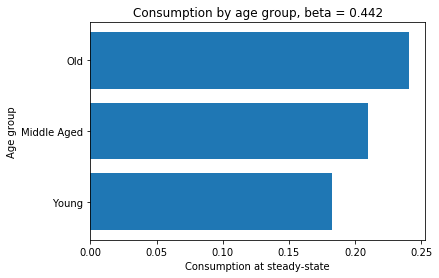

{'b_ss': array([0.01931262, 0.05841243]), 'c_ss': [0.18241332984586706, 0.2096142411367639, 0.2408765622579139], 'w_ss': 0.20172594930955895, 'r_ss': 2.433025771148647, 'K_ss': 0.07772504796372812, 'Y_ss': 0.6827647515092765, 'C_ss': 0.6329041332405448, 'EulErr_ss': array([-0.00253831,  0.0054862 ]), 'RCerr_ss': 9.020562075079397e-17, 'ss_time': 0.0009335462683535922}


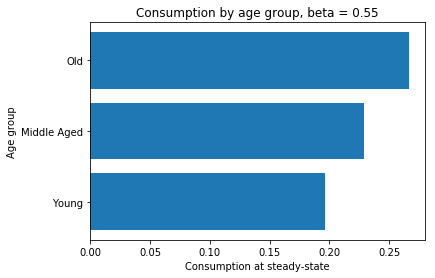

{'b_ss': array([0.02818307, 0.07686099]), 'c_ss': [0.19597038673396155, 0.22863868705115642, 0.2666784110010002], 'w_ss': 0.22415346070701764, 'r_ss': 1.8863500166253273, 'K_ss': 0.10504406365960055, 'Y_ss': 0.7586732516237521, 'C_ss': 0.6912874847861181, 'EulErr_ss': array([ 0.05081364, -0.03801077]), 'RCerr_ss': 2.220446049250313e-16, 'ss_time': 0.2696395649537856}


In [3]:
def uprime(c, sigma):
    '''
    Input is some level of consumption and CRRE parameter sigma
    uprime 
    '''
    if c <= 1e-6:
        uprime = 1e20
    else:
        uprime = c ** (- sigma)
    return uprime
#uprime()

def euler_errors(bvec, params):
    '''
    This function calculates the difference between the euler 
    equations for the age 1 householods and the age 2 households.
    fparams is a prameter vector [nvec, A, alpha, delta]
    bvec_guess is the guess for bvec
    Output is eulerr = [diff1, diff2]
    This is what we will try to set = 0 to optimize
    '''
    #Name things
    nvec, A, alpha, delta, beta, sigma = params
    w = get_w(bvec, [nvec, A, alpha])
    r = get_r(bvec, [nvec, A, alpha, delta])
    b_2, b_3 = bvec[0], bvec[1]
    n_1, n_2, n_3 = nvec[0], nvec[1], nvec[2]
    #Define Euler differences
    eulerr1 = uprime((w - b_2), sigma) - beta * (1 + r) * uprime((w + (1 + r) * b_2 - b_3), sigma)
    eulerr2 = uprime((w + (1 + r) * b_2 - b_3), sigma) - beta * (1+r) * uprime(((1 + r) * b_3 + n_3 * w), sigma)
    return (eulerr1, eulerr2)

#print(euler_errors([1.56e+7, 4.98e+22], [[1, 1, .2], 1, .35, .6415, .442, .3]))

def c(bvec, nvec, w, r):
    c1 = w * nvec[0] - bvec[0]
    c2 = bvec[0] * (1+r) + w * nvec[1] - bvec[1]
    c3 = bvec[1] * (1+r) + w * nvec[2]
    cvec = [c1, c2, c3]
    return cvec

def get_SS(params, bvec_guess, SS_graphs=False):
    '''
    Inputs are the parameters for the model (defined below), an initial
    guess of the steady sate savings, and a boolean withc tells me to
    plot anything. Output ss_output has a variety of different factors
    which are given in the definition.
    '''
    time.clock()
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    optimizer = opt.root(euler_errors, bvec_guess, args =[nvec, A, alpha, delta, beta, sigma], tol = SS_tol)
    b_ss = optimizer.x
    w_ss = get_w(b_ss, [nvec, A, alpha])
    r_ss = get_r(b_ss, [nvec, A, alpha, delta])
    c_ss = c(b_ss, nvec, w_ss, r_ss)
    K_ss = np.sum(b_ss)
    Y_ss = (A * K_ss ** alpha) * (L ** (1-alpha))
    C_ss = np.sum(c_ss)
    EulErr_ss = optimizer.fun
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    ss_time = time.clock()
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    if SS_graphs == True:
        plt.barh(["Young", "Middle Aged", "Old"], c_ss)
        plt.ylabel("Age group")
        plt.xlabel("Consumption at steady-state")
        plt.title(f"Consumption by age group, beta = {beta}")
        plt.show()
    return ss_output
        
#Run function
params = [.442, 3, [1, 1, .2], 2.2, 1, .35, .6415, .01]
bvec_guess = [.1,.1]
print(get_SS(params, bvec_guess, SS_graphs = True))

#Now with new beta
params = [.55, 3, [1, 1, .2], 2.2, 1, .35, .6415, .01]
print(get_SS(params, bvec_guess, SS_graphs = True))

When we increase beta, we see that savings in both the young and middle-aged increases. Interestingly, so does consumption in all age groups, but the largest effect is in the old. Wages increase, and interst rates decrease.

## Exercise 3

In [4]:
# Step 1/2/3: Get Parameters, initial state, and steady state.
# params = beta, sigma, nvec, L, A, alpha, beta, tol
beta = .442
delta = .6415
nvec = [1, 1, .2]
L = 2.2
A = 1
alpha = .35
sigma = 3
T = 25
tol = 1e-9

params = [beta, sigma, nvec, L, A, alpha, delta, T, tol]

#Get SS savings:
b_ss = get_SS([beta, sigma, nvec, L, A, alpha, delta, .01], [.1,.1])['b_ss']
b_2_ss = b_ss[0]
b_3_ss = b_ss[1]
K_ss = b_2_ss + b_3_ss
#print("SS,", b_2_ss, b_3_ss, K_ss)

#Compute intial savings as required
b_2_1 = 0.8*b_2_ss
b_3_1 = 1.1*b_3_ss
K_1 = b_2_1 + b_3_1
#print("Initial", b_2_1, b_3_1, K_1)
b_i = [b_2_1, b_3_1]

#Re-configure some functions to take K as arguments rather than b.
def get_w3(K, argsw):
    '''
    K is the capital stock in the period.
    argsw is a parameters vector [nvec, A, alpha]
    Output is w_t the wage rate.
    '''
    nvec, A, alpha = argsw
    w = (1 - alpha) * A * (K / np.sum(nvec)) ** alpha
    return w

def get_r3(K, argsr):
    '''
    K is the capital stock in the period.
    argsw is a parameters vector [nvec, A, alpha, delta]
    Output is r_t the intrest rate.
    '''
    nvec, A, alpha, delta = argsr
    r = alpha * A * (np.sum(nvec) / K) ** (1 - alpha) - delta
    return r

def euler_errors3(bvec, params):
    '''
    This function calculates the difference between the euler 
    equations for the age 1 householods and the age 2 households.
    fparams is a prameter vector [nvec, A, alpha, delta]
    bvec_guess is the guess for bvec
    Output is eulerr = [diff1, diff2]
    This is what we will try to set = 0 to optimize Household decisions.
    '''
    #Name things
    wvec, rvec, nvec, A, alpha, delta, beta, sigma = params
    w_1, w_2, w_3 = wvec[0], wvec[1], wvec[2]
    r_1, r_2, r_3 = rvec[0], rvec[1], rvec[2]
    b_22, b_33 = bvec[0], bvec[1]
    n_1, n_2, n_3 = nvec[0], nvec[1], nvec[2]
    #Define Euler differences
    eulerr1 = uprime((w_1 * n_1 - b_22), sigma) - beta * (1 + r_2) * uprime((w_2 * n_2 + (1 + r_2) * b_22 - b_33), sigma)
    eulerr2 = uprime((w_2 * n_2 + (1 + r_2) * b_22 - b_33), sigma) - beta * (1+r_3) * uprime(((1 + r_3) * b_33 + n_3 * w_3), sigma)
    return (eulerr1, eulerr2)


#Step 4: Guess a Path between current state and steady state capital
# My guess is just linear
Kpath = np.linspace(K_1, K_ss, T)
# I'll append 2 more observations at the steady-state.
Kpath = np.append(Kpath, [Kpath[T-1], Kpath[T-1]])
# Step 5: Solve for individual's lifetime decisons
# Define some functions that let me do this.

def solveHHpaths(b_i, Kpath, params):
    '''
    Function takes as input Kpath a capital path and params.
    It solves for the optimal household savings decisions for
    all households in all time periods given this capital path
    (and rational expectations). Output is a matrix in which the
    first column is all the b_2_t in order, second column is the
    b_3_t. There is notably a hole here: I can't get b_32 in the 
    ordinary way, so I fill it in by using another function.
    '''
    beta, sigma, nvec, L, A, alpha, delta, T, tol = params
    # Get rpath and wpath
    r_path = get_r3(Kpath, [nvec, A, alpha, delta])
    w_path = get_w3(Kpath, [nvec, A, alpha])
    # Solve via twist donut: get b_2t, b_3(t+1):
    #Initialize bmat
    bmat = np.zeros((T+1, 2))
    eulerr = np.zeros((T+1, 2))
    bmat[0, 0] = b_i[0]
    bmat[0, 1] = b_i[1]
    for t in range (T-1):
        # Set up params for euler_errors function (Test case: b_22, b_33)
        # This should ge giving me w_t, w_t+1, w_t+2, and same for r.
        wvect = w_path[t:t+3] 
        rvect = r_path[t:t+3]
        eeparams = wvect, rvect, nvec, A, alpha, delta, beta, sigma
        # Throw through a root finder.
        bvec_guess = [b_2_ss, b_3_ss]
        HHoptimizer = opt.root(euler_errors3, bvec_guess, args =[wvect, rvect, nvec, A, alpha, delta, beta, sigma], tol = .01)
        bmat[t+1, 0] = HHoptimizer.x[0]
        bmat[t+2, 1] = HHoptimizer.x[1]
        #I'll include a matrix to track my errors.
        eulerr[t+1, :] = HHoptimizer.fun
    # Truncate (cut off T+1st row)
    bmat = bmat[:-1, :]
    # Add b_3_2
    b_3_2 = solveHH32(Kpath, b_2_1, wvect, rvect, params)
    bmat[1, 1] = b_3_2
    return bmat, eulerr

def euler_error_b32(b_3_2, params):
    '''
    This is the function that I'm maximizing over in the solveHH32
    function. There's only one equation with one unknown, this time.
    params = b_2_1, beta, sigma, nvec, L, A, alpha, delta, T, tol
    '''
    #Naming
    b_2_1, wvec, rvec, beta, sigma, nvec, L, A, alpha, delta, T, tol = params
    w_1, w_2, w_3 = wvec[0], wvec[1], wvec[2]
    r_1, r_2, r_3 = rvec[0], rvec[1], rvec[2]
    n_1, n_2, n_3 = nvec[0], nvec[1], nvec[2]
    eulerr = uprime(w_1 * n_2 + (1 + r_1) * b_2_1 - b_3_2, sigma) - beta * (1 + r_2) * uprime((1+r_2)*b_3_2 + w_2 *n_3, sigma)
    return eulerr

def solveHH32(Kpath, b_2_1, wvec, rvec, params):
    '''
    This function is created to fill the hole in the output
    of the earlier function and solve for b_32. Takes same
    inputs, plus an additional input for knowing what is b_21. 
    Only output is the integer b_32.
    '''
    beta, sigma, nvec, L, A, alpha, delta, T, tol = params
    b32_guess = b_3_ss
    b32optimizer = opt.root(euler_error_b32, b32_guess, args = [b_2_1] + [wvec] + [rvec] + params, tol = .01)
    return b32optimizer.x


SS, 0.019312619463691887 0.05841242850003624 0.07772504796372812
Initial 0.01545009557095351 0.06425367135003987 0.07970376692099337


Max Euler Error: 0.0036272300831683424 
Max Resource Error: 0.017101882660571863 
 This resource error seems a bit high to me, I may have made a mistake somewhere.


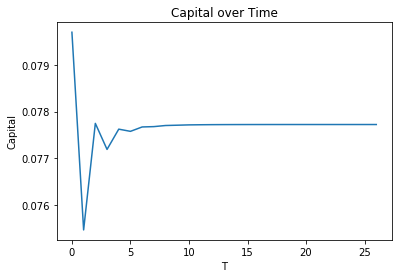

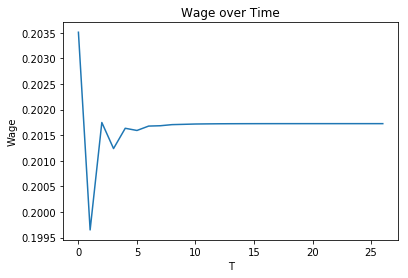

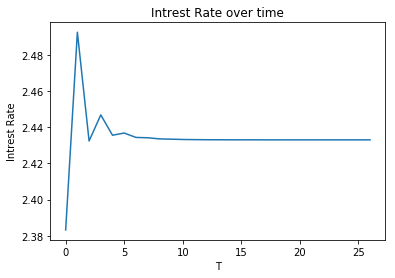

(array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
      dtype=int64),) 
We see from the above that at T = 10, the function gets within .00001 of the steady state capital, and it never leaves this window again.


In [53]:
'''
Anyways. Now that I have functions which give me the new 
household paths, it is time to iterate through the capital 
paths until they converge.
'''

def Kprime(Bmat):
    '''
    Pulls a new capital path from Bmat, adding up the optimal
    household savings for the young and the middle aged.
    '''
    Kprime = Bmat[:, 0] + Bmat[:, 1]
    Kprime = np.append(Kprime, [Kprime[T-1], Kprime[T-1]])
    return Kprime

def Kiter(b_i, Kpath_guess, params, xi = .15, maxiter = 5000, tol = 1e-9):
    '''
    Iterates through successive capital paths until they 
    converge to a stable path. The function creates a bmatrix
    of household decisions from each new path, from which it
    draws a kprime. Then it checks the distance between k and
    kprime. If they have not yet converged, it creates a new k
    from a linear combination of k and kprime, and then repeats 
    the process
    '''
    beta, sigma, nvec, L, A, alpha, delta, T, tol = params
    #Initialize things
    Kdist = 5
    iter = 1
    Kpath = Kpath_guess
    #Enter loop
    while (Kdist > tol) & (iter<maxiter):
        Bmat = solveHHpaths(b_i, Kpath, params)[0]
        Kpr = Kprime(Bmat)
        Kdist = la.norm(Kpath-Kpr)
        #print("Iter =", iter, "Kdist =", Kdist)
        Kpath = Kpr * xi + (1- xi) * Kpath
        iter += 1
    Bmatfinal = solveHHpaths(b_i, Kpath, params)[0]
    Eulerr = solveHHpaths(b_i, Kpath, params)[1]
    Maxeuler = np.amax(abs(Eulerr))
    Ypath = (A * Kpath ** alpha) * (L **(1-alpha))
    Wpath = get_w3(Kpath, [nvec, A, alpha])
    Rpath = get_r3(Kpath, [nvec, A, alpha, delta])
    Cpath = conspath(Bmatfinal, Wpath, Rpath, params)
    Rerrorpath = np.zeros(T)
    for i in range(1, T):
        Rerrorpath[i] = abs(Ypath[i] - Cpath[i] - Kpath[i+1] + (1 - delta) * Kpath[i])
    Maxrerror = max(Rerrorpath)
    Kiter_output = {
        'Kpath': Kpath, 'Bmat': Bmatfinal, 'Ypath': Ypath,
        'Wpath': Wpath, 'Rpath': Rpath, 'Maxeuler': Maxeuler, 
        'Cpath': Cpath, 'Rerrorpath': Rerrorpath, 'Maxrerror': Maxrerror}
    return Kiter_output

'''
I need to define some more functions to learn about the 
error associated with this process.
'''

def conspath(Bmat, Wpath, Rpath, params):
    '''
    Given a Bmat, Wpath, and Rpath, defines a consumption
    path.
    '''
    c_1path = np.zeros(T)
    c_2path = np.zeros(T)
    c_3path = np.zeros(T)
    for i in range(1, T):
        c_1path[i] = Wpath[i] * nvec[0] - Bmat[i, 0]
        c_2path[i] = Wpath[i] * nvec[1] + (1+Rpath[i])*Bmat[i-1, 0] - Bmat[i, 1]
        c_3path[i] = Wpath[i] * nvec[2] + (1+Rpath[i])*Bmat[i-1, 1]
    Cpath = c_1path + c_2path + c_3path
    return Cpath

K_path_guess = Kpath                                                                       
final = Kiter(b_i, K_path_guess, params)
print("Max Euler Error:", final['Maxeuler'], "\nMax Resource Error:", final['Maxrerror'], "\n This resource error seems a bit high to me, I may have made a mistake somewhere.")

plt.plot(soln['Kpath'])
plt.xlabel("T")
plt.ylabel("Capital")
plt.title("Capital over Time")
plt.show()

plt.plot(soln['Wpath'])
plt.xlabel("T")
plt.ylabel("Wage")
plt.title("Wage over Time")
plt.show()

plt.plot(soln['Rpath'])
plt.xlabel("T")
plt.ylabel("Intrest Rate")
plt.title("Intrest Rate over time")
plt.show()

difference = abs(soln['Kpath'] - K_ss)
print(np.where(difference < .00001), "\nWe see from the above that at T = 10, the function gets within .00001 of the steady state capital, and it never leaves this window again.")